# The main task is looking for dependation between 3 data type: average month temperature and month number vs. month electricity energy usage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, LinearLocator
import seaborn as sns

In [2]:
energy = pd.read_csv('elusage.csv', index_col = False)

In [3]:
energy.head(10)

,average_temperature,month,average_electricity_usage
0,73,8,24.828
1,67,9,24.688
2,57,10,19.310
3,43,11,59.706
4,26,12,99.667
5,41,1,49.333
6,38,2,59.375
7,46,3,55.172
8,54,4,55.517
9,60,5,25.938


### Getting informations about DataFrame (e.g. inproper/missing values and types of data used)

In [4]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   average_temperature        55 non-null     int64  
 1   month                      55 non-null     int64  
 2   average_electricity_usage  55 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.4 KB


#### **There are no missing values and all of them are numeric types**

### After DataFrame was made and check we need to give it as simple form as possible, so we will make column names shorter by removing useless `'average_'` substring (we know that every number in these 2 columns are the average values calculated from many observations taken during every month).

In [5]:
energy = energy.rename(columns={'average_temperature': 'temperature',
                                'average_electricity_usage': 'electricity_usage'})
print(energy)

    temperature  month  electricity_usage
0            73      8             24.828
1            67      9             24.688
2            57     10             19.310
3            43     11             59.706
4            26     12             99.667
5            41      1             49.333
6            38      2             59.375
7            46      3             55.172
8            54      4             55.517
9            60      5             25.938
10           71      6             20.690
11           75      7             24.333
12           74      8             22.759
13           66      9             24.688
14           61     10             22.759
15           49     11             50.588
16           41     12             79.000
17           35      1             87.188
18           41      2             47.333
19           42      3             38.621
20           56      4             27.931
21           69      5             25.000
22           73      6            

---

## Global plot settings as a function

In [6]:
def global_plot_sets():
    plt.rc('xtick', color = 'k', labelsize = 18)
    plt.rc('ytick', color = 'k', labelsize = 18)
    plt.rc('axes', labelsize = 24, labelpad = 18, titlepad = 12,
           titlesize = 28, facecolor = '#c6c6c6', axisbelow = 'True')
    plt.rc('grid', color = 'w', linestyle = '-.', linewidth = 0.6)
    plt.rc('legend', facecolor = 'w', fontsize = 16)
    plt.rc('xtick.major', size = 8, width = 1)
    plt.rc('xtick.minor', size = 5, width = 1)
    plt.rc('ytick.major', size = 8, width = 1)
    plt.rc('ytick.minor', size = 5, width = 1)

## Plots displaying dependancy between measured data

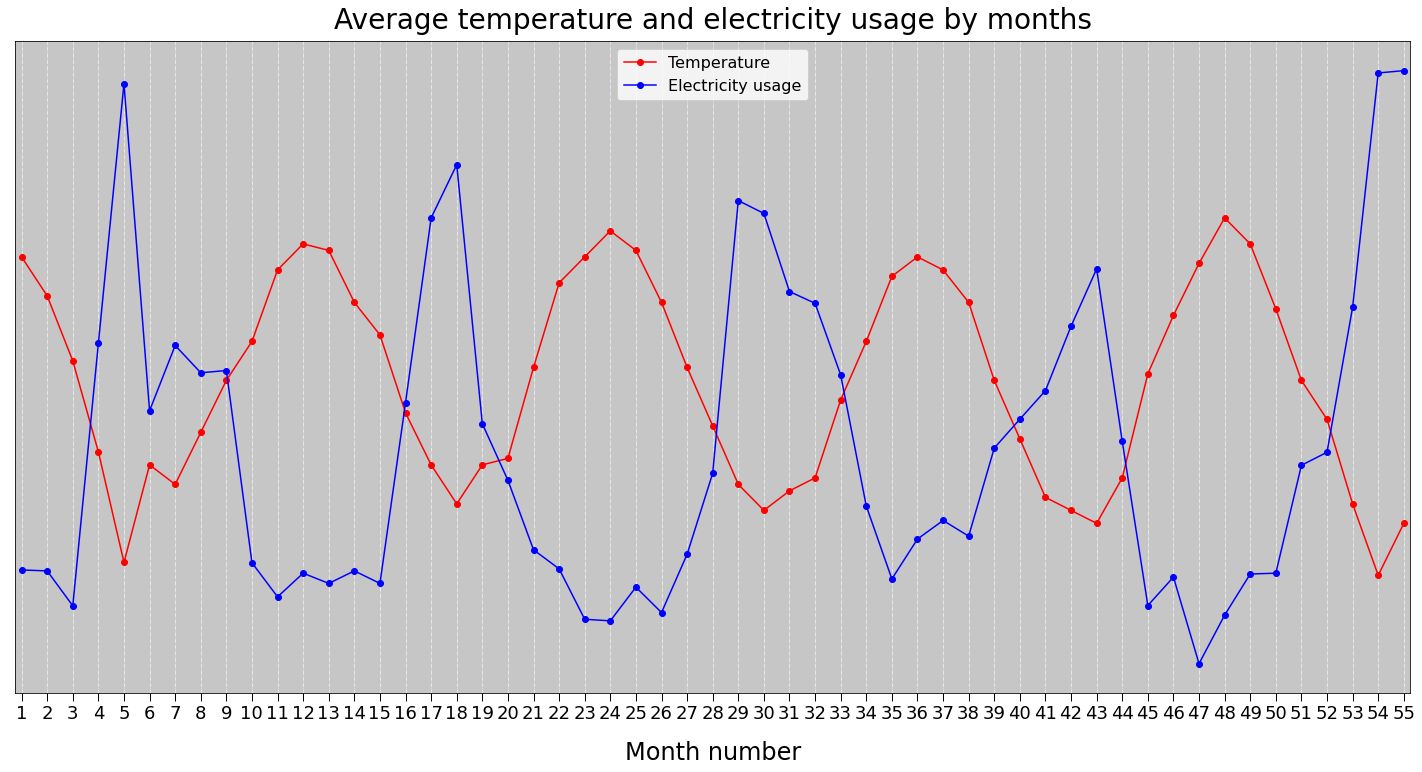

In [7]:
global_plot_sets()
plt.figure(figsize=(25, 12))

# Number of observations in the column
x_range = np.arange(1, len(energy) + 1)

plt.plot(x_range, energy['temperature'], c = 'red', marker = 'o', label = 'Temperature')
plt.plot(x_range, energy['electricity_usage'], c = 'blue', marker = 'o', label = 'Electricity usage')
plt.xlabel('Month number')
plt.xlim(x_range.min() - 0.25, x_range.max() + 0.25)
plt.xticks(x_range)
plt.yticks([])
plt.grid()
plt.title('Average temperature and electricity usage by months')
plt.legend(loc='upper center')

plt.show()

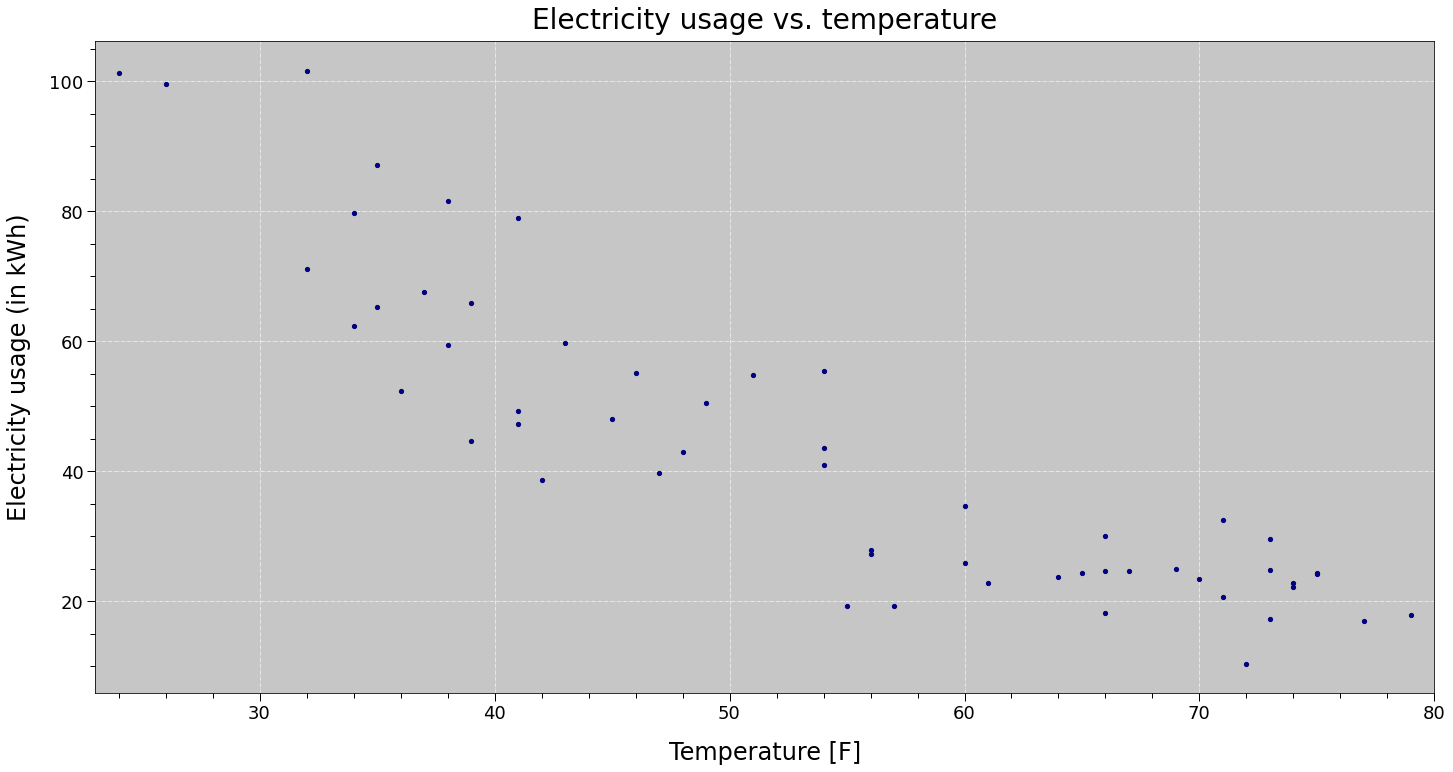

In [8]:
global_plot_sets()
plt.figure(figsize=(24, 12))

plt.scatter(energy['temperature'], energy['electricity_usage'], c = 'navy', marker = 'o', s = 18)
plt.xlabel('Temperature [F]')
plt.ylabel('Electricity usage (in kWh)')
plt.xlim(energy['temperature'].min() - 1, energy['temperature'].max() + 1)
plt.minorticks_on()
plt.grid()
plt.title('Electricity usage vs. temperature')

plt.show()

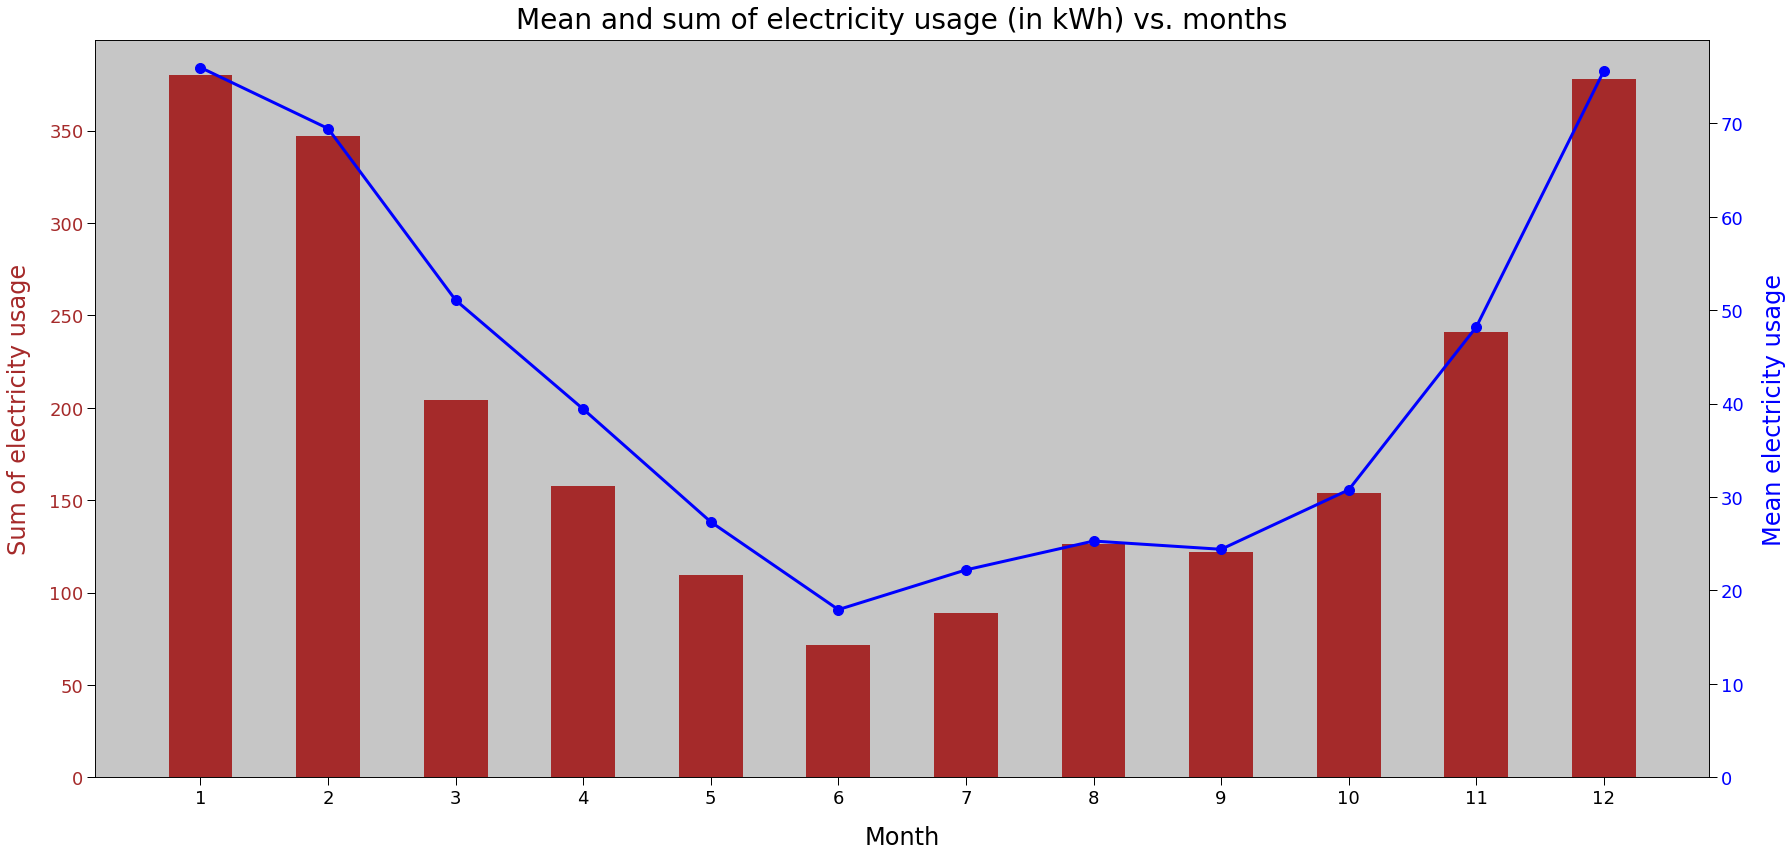

In [9]:
fig, ax1 = plt.subplots(figsize=(25, 12))
ax2 = ax1.twinx()

# Mean and sum values
months_mean_energy_used = energy.groupby('month')['electricity_usage'].mean()
months_sum_energy_used = energy.groupby('month')['electricity_usage'].sum()

month_number = months_sum_energy_used.keys()
w = 0.5   # bar width

ax1.bar(month_number, months_sum_energy_used, width = w, color = 'brown', linewidth=0)
ax2.plot(month_number, months_mean_energy_used, color = 'blue', linewidth=3, marker='o', markersize=10)
ax1.set_xlabel('Month')
ax1.set_ylabel('Sum of electricity usage', color='brown')
ax2.set_ylabel('Mean electricity usage', color='blue')
ax1.tick_params(axis='y', labelcolor='brown')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(ymin=0)
plt.title('Mean and sum of electricity usage (in kWh) vs. months')
ax1.set_xticks(month_number)    

fig.tight_layout()
plt.show()

---

# **Statistics for data set**

## Compare basic stats for `'temperature'` and `'electricity_usage'` data

In [10]:
energy[['temperature', 'electricity_usage']].describe().round(1)

,temperature,electricity_usage
count,55.0,55.0
mean,53.8,43.3
std,15.5,24.0
min,24.0,10.4
25%,40.0,24.3
50%,54.0,38.6
75%,68.0,57.4
max,79.0,101.7


#### `'temperature'` column data is close to normal distribution, but `'electricity_usage'` is right-skewed (the largest number of observations are on the left side of histogram) - all `'electricity_usage'` observations will be transform by using a few the most common function:
- BoxCox (*normalization*),
- RobustScaler,
- QuantileTransformer,
- minmax_scale.

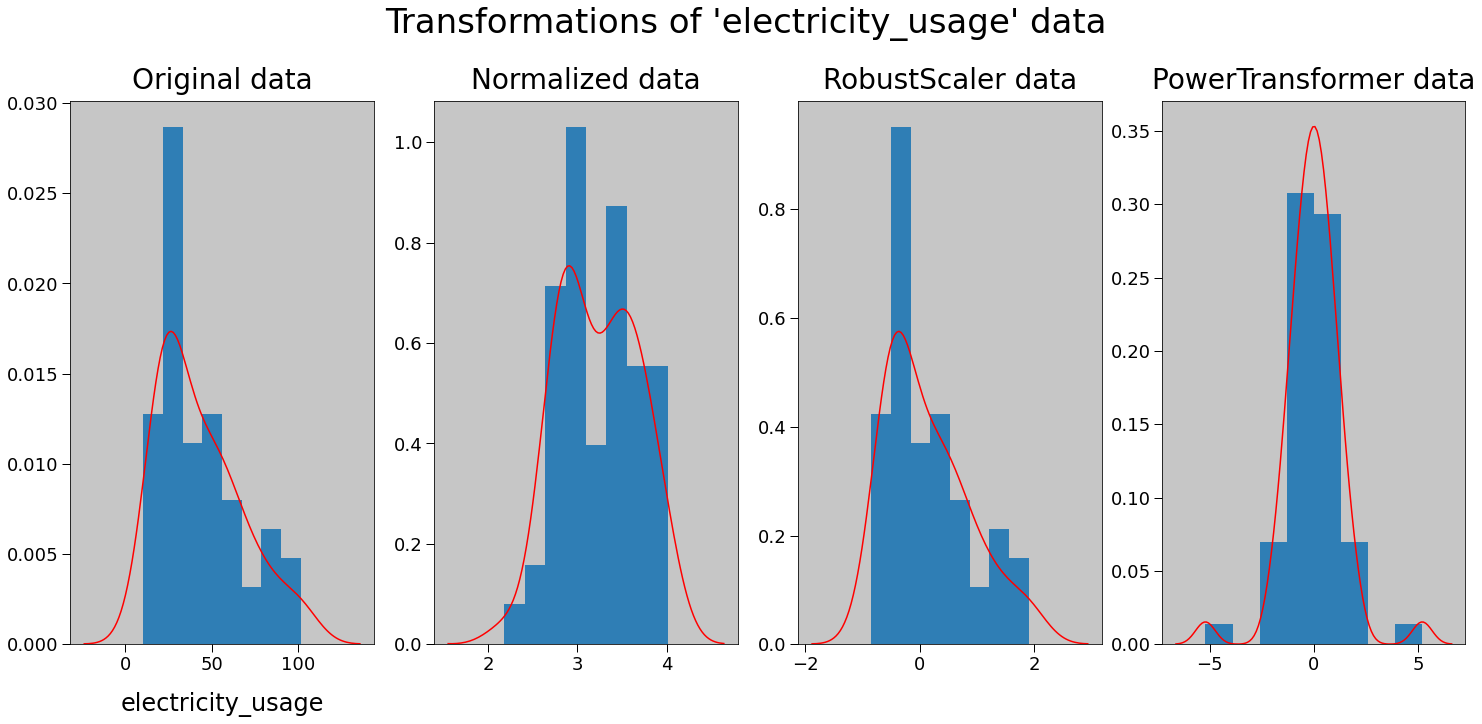

In [11]:
fig = plt.figure(figsize=(25, 10))

ax_ = [fig.add_subplot(1, 4, pos) for pos in range(1, 5)]

from scipy import stats # for Box-Cox Transformation
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

original_data = energy['electricity_usage']
# reshape data to make 'fit_transform' operations
original_data_reshape = np.array(original_data).reshape(-1,1)

# 
Normalized_data = stats.boxcox(original_data)
RobustScaler_data = RobustScaler(quantile_range=(25, 75)).fit_transform(original_data_reshape)
PowerTransformer_data = QuantileTransformer(output_distribution='normal', n_quantiles=len(original_data)).fit_transform(original_data_reshape)
Scaled_data = minmax_scale(original_data)

func_titles = ['Original data', 'Normalized data', 'RobustScaler data', 'PowerTransformer data', 'MinMax_scale data']
transformed_data = [original_data, Normalized_data[0], RobustScaler_data, PowerTransformer_data, Scaled_data]

plt.suptitle("Transformations of 'electricity_usage' data", fontsize = 34, y=1.01)

for hist_titles, hist_data, axs in zip(func_titles[0:4], transformed_data[0:4], ax_):
    sns.distplot(hist_data, bins = np.math.ceil(np.sqrt(len(original_data))),
                 kde_kws={"color": "red", "lw": 1.5},
                 hist_kws={"linewidth": 0, "alpha": 0.9}, ax=axs)
    axs.set_title(hist_titles)

plt.show()

---

## Looking for *Pearson* and *Spearman correlation*

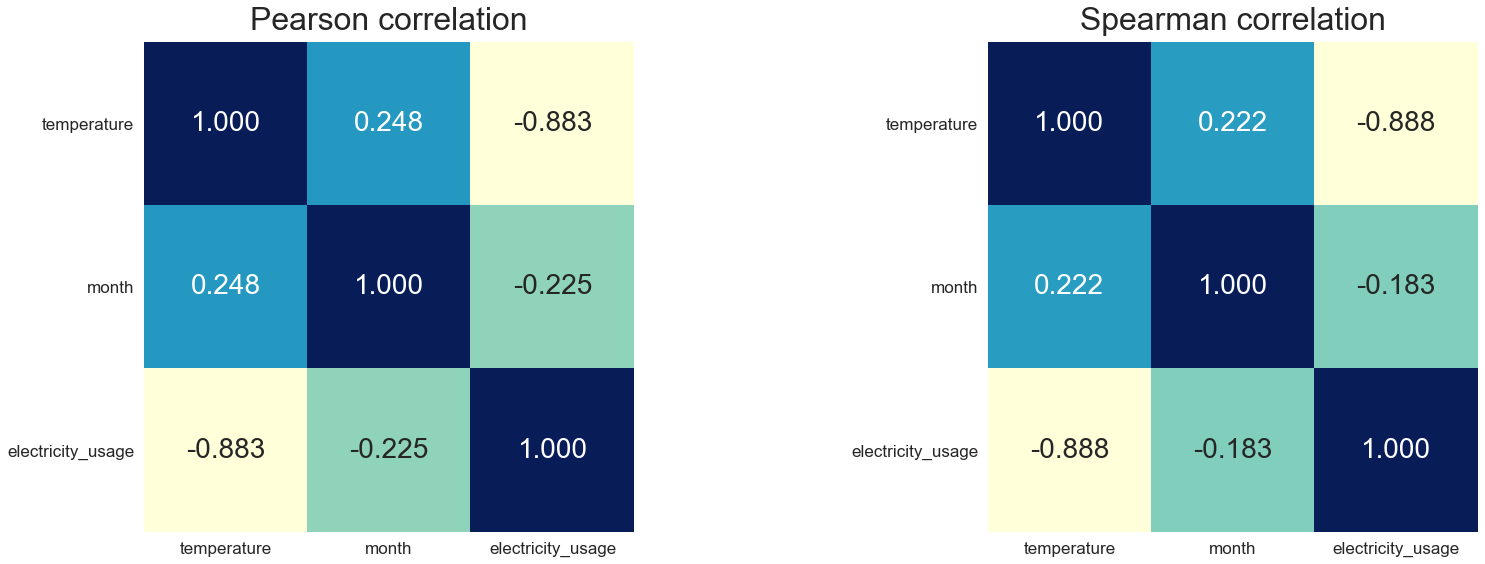

In [12]:
sns.set()

# Draw a heatmap with the numeric values in each cell
fig = plt.figure(figsize=(25, 8))

ax_ = [fig.add_subplot(1, 2, pos) for pos in [1,2]]
correlation_data = [energy.corr(method = option) for option in ['pearson', 'spearman']]
titles_array = ['Pearson correlation', 'Spearman correlation']

# We use axs parameter to tell seaborn which subplot to use for this plot
for axs, data, titles in zip(ax_, correlation_data, titles_array):
    sns.heatmap(data = data, square = True, cmap = "YlGnBu", cbar=False,
                fmt = '.3f', annot = True, annot_kws = {"fontsize": 28}, ax = axs)
    axs.set_xticklabels(ax_[0].get_xticklabels(), fontsize = 17)
    axs.set_yticklabels(ax_[0].get_xticklabels(), fontsize = 17,
                        rotation = 0, ha = "right", rotation_mode = "anchor")
    axs.set_title(titles, fontsize = 32)
    
plt.tight_layout()
plt.show()

## **Conclusions:** 
### - `'month'` vs. `'electricity usage'` do not have enough strong linear and non-linear correlations, although plot show clear cyclical (seasonal) dependancy,
### - `'temperature'` and `'electricity_usage'` have got strong ***Spearman correlation***, so regression will be made using linear algorythms and with decision tree.

---

## Polynomial functions using to compare will have degrees between 1. and 5. - higher degree values than 5. could be a reason of overfitting the final model.

# Linear regression methods

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
x_temperature = energy['temperature']

# 'x_temperature_reshape' is necessary for the properly working of some transform functions
x_temperature_reshape = np.array(x_temperature).reshape(-1,1)

# Transformation results presented in one array to use it in the later calculations
temperature_transformed = [stats.boxcox(x_temperature)[0],
                           RobustScaler(quantile_range=(25, 75)).fit_transform(x_temperature_reshape),
                           QuantileTransformer(output_distribution='normal', n_quantiles=len(x_temperature)).fit_transform(x_temperature_reshape),
                           minmax_scale(x_temperature)]


# Results as the DataFrames
def DataFrame_with_transformation(i):
    X_temperature = np.array(temperature_transformed[i]).reshape(-1,1)
    if (i==0 or i==1):
        y_transformed = transformed_data[i]
    else:
        y_transformed = transformed_data[i][:, 0]
    return pd.DataFrame({'X': X_temperature.flatten(), 'y': y_transformed})

### After making DataFrames we need to reorganize data by ascending order on x-axis - only then it is possible to draw the plots properly.

In [15]:
## Sorting x values in the DataFrames for every transformation functions used

def sorted_x_values(k):
    return DataFrame_with_transformation(k).sort_values('X')

## **Polynomial regression** (1. to 5. degrees)

In [16]:
from sklearn.preprocessing import PolynomialFeatures

model = LinearRegression()
n = np.arange(1, 6)

def poly_regression(n, k):
    poly_pred_array = []
    polynomial_features = PolynomialFeatures(degree = n)
    if (k in range(0, 4)):
        x_temperature_sort, y = sorted_x_values(k).iloc[:, 0:1], sorted_x_values(k).iloc[:, 1]    
        x_poly = polynomial_features.fit_transform(x_temperature_sort)
    else:
        y = original_data_reshape
        x_poly = polynomial_features.fit_transform(np.array(x_temperature).reshape(-1, 1))
    y_poly_pred = model.fit(x_poly, y).predict(x_poly)
    poly_pred_array.append([x_poly[:, 1], y_poly_pred])
    
    rmse = np.sqrt(mean_squared_error(y, y_poly_pred))
    r2 = r2_score(y, y_poly_pred, multioutput = 'variance_weighted')
    print('For "{}" results are: RMSE = {:.3f}, R2 = {:.3f} ({}. degree function)'.format(func_titles[k+1], rmse, r2, n))
    
    return [poly_pred_array, rmse, r2, n]
    

## Final RMSE and R2 results (original data + 4 transformation functions)

poly_original_results = [poly_regression(x, -1) for x in n]
poly_boxcox_results = [poly_regression(x, 0) for x in n] # normalized_data[0]
poly_robustscaler_results = [poly_regression(x, 1) for x in n]
poly_yeojohnson_results = [poly_regression(x, 2) for x in n] # PowerTransformer_data
poly_minmax_results = [poly_regression(x, 3) for x in n]

For "Original data" results are: RMSE = 11.146, R2 = 0.780 (1. degree function)
For "Original data" results are: RMSE = 9.309, R2 = 0.847 (2. degree function)
For "Original data" results are: RMSE = 9.300, R2 = 0.847 (3. degree function)
For "Original data" results are: RMSE = 9.299, R2 = 0.847 (4. degree function)
For "Original data" results are: RMSE = 9.294, R2 = 0.847 (5. degree function)
For "Normalized data" results are: RMSE = 10.948, R2 = 0.788 (1. degree function)
For "Normalized data" results are: RMSE = 9.301, R2 = 0.847 (2. degree function)
For "Normalized data" results are: RMSE = 9.301, R2 = 0.847 (3. degree function)
For "Normalized data" results are: RMSE = 9.300, R2 = 0.847 (4. degree function)
For "Normalized data" results are: RMSE = 9.298, R2 = 0.847 (5. degree function)
For "RobustScaler data" results are: RMSE = 0.194, R2 = 0.802 (1. degree function)
For "RobustScaler data" results are: RMSE = 0.190, R2 = 0.810 (2. degree function)
For "RobustScaler data" results 

## Before comparing the results we have to remember that the best RMSE value means the lowest (ideally when 0), but the best R2 means the highest value (ideally 1).

### 'Normalized'(`'BoxCox'`) and 'original' data give the highest R2 values for all calculations made - only for n=1 normalization result is a little better (0.788 vs. 0.780).
### Different situation is for RMSE results - here we see that for `'PowerTransformer'` function it is possible to achieve R2 value (with n=4) almost as high as for 'original' and 'normalized'(`'BoxCox'`) results, but RMSE is 30 times lower.

## **Conclusion**: Optimal polynomial regression method is `'PowerTransformer'` with n=4 (4. degree polynomial function used).